In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
from scipy.stats.contingency import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras import models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from collections import Counter




import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/credit-score-classification


In [4]:
train_df = pd.read_csv("/kaggle/input/credit-score-classification/train.csv")
train_df["is_train"] = True

test_df = pd.read_csv("/kaggle/input/credit-score-classification/test.csv")  
test_df["is_train"] = False

df = pd.concat([train_df, test_df])

In [5]:
df0 = df.copy()
df.duplicated().sum() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  object 
 3   Name                      135000 non-null  object 
 4   Age                       150000 non-null  object 
 5   SSN                       150000 non-null  object 
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  object 
 8   Monthly_Inhand_Salary     127500 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  int64  
 10  Num_Credit_Card           150000 non-null  int64  
 11  Interest_Rate             150000 non-null  int64  
 12  Num_of_Loan               150000 non-null  object 
 13  Type_of_Loan              132888 non-null  object 

# Feature

In [6]:
df = df[df['Payment_Behaviour'] != '!@9#%8']  
df[['Spending_Level', 'Payment_Value']] = df['Payment_Behaviour'].str.split('_', n=1, expand=True) 
df['Payment_Value'] = df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  
df['Payment_Value'] = df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  # Bu satır aynı kalıyor
df['Payment_Value'] = df['Payment_Value'].str.replace('spent_', '')

In [7]:
def convert_to_months(age_str):
    if pd.isna(age_str):  
        return 0
    parts = age_str.split()
    years = int(parts[0])  
    months = int(parts[3])  
    return years * 12 + months  

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_months) 
# NaNs have been transformed 0

In [8]:
drop_columns = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month','Type_of_Loan', 'Payment_Behaviour']

In [9]:
df.drop(drop_columns, axis=1, inplace=True)

# EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138600 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       138600 non-null  object 
 1   Occupation                138600 non-null  object 
 2   Annual_Income             138600 non-null  object 
 3   Monthly_Inhand_Salary     117809 non-null  float64
 4   Num_Bank_Accounts         138600 non-null  int64  
 5   Num_Credit_Card           138600 non-null  int64  
 6   Interest_Rate             138600 non-null  int64  
 7   Num_of_Loan               138600 non-null  object 
 8   Delay_from_due_date       138600 non-null  int64  
 9   Num_of_Delayed_Payment    128968 non-null  object 
 10  Changed_Credit_Limit      138600 non-null  object 
 11  Num_Credit_Inquiries      135841 non-null  float64
 12  Credit_Mix                138600 non-null  object 
 13  Outstanding_Debt          138600 non-null  object 

In [11]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,is_train,Spending_Level,Payment_Value
0,23,Scientist,19114.12,"1,824.84",3,4,3,4,3,7,11.27,4.00,_,809.98,26.82,265,No,49.57,80.41529543900253,312.49408867943663,Good,True,High,Small
1,23,Scientist,19114.12,NaN,3,4,3,4,-1,NaN,11.27,4.00,Good,809.98,31.94,0,No,49.57,118.28022162236736,284.62916249607184,Good,True,Low,Large
2,-500,Scientist,19114.12,NaN,3,4,3,4,3,7,_,4.00,Good,809.98,28.61,267,No,49.57,81.699521264648,331.2098628537912,Good,True,Low,Medium
3,23,Scientist,19114.12,NaN,3,4,3,4,5,4,6.27,4.00,Good,809.98,31.38,268,No,49.57,199.4580743910713,223.45130972736786,Good,True,Low,Small
4,23,Scientist,19114.12,"1,824.84",3,4,3,4,6,NaN,11.27,4.00,Good,809.98,24.80,269,No,49.57,41.420153086217326,341.48923103222177,Good,True,High,Medium


In [12]:
num_cols = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card","Interest_Rate","Num_of_Loan", "Delay_from_due_date","Num_of_Delayed_Payment","Changed_Credit_Limit", "Num_Credit_Inquiries","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly",	"Monthly_Balance","Credit_History_Age"] 
cat_cols = ["Occupation","Credit_Mix", "Spending_Level","Payment_Value","Payment_of_Min_Amount"]  
target_col = ["Credit_Score"]

In [13]:
class DataCleaner:
    def __init__(self, dataframe, numeric_columns):
        self.dataframe = dataframe
        self.numeric_columns = numeric_columns

    def clean_numeric_columns(self):
        
        for col in self.numeric_columns:
            
            if self.dataframe[col].dtype == 'object': 
                self.dataframe[col] = self.dataframe[col].str.extract(r'(\d+)')
                self.dataframe[col] = pd.to_numeric(self.dataframe[col], errors='coerce')
                self.dataframe[col] = self.dataframe[col].fillna(self.dataframe[col].median())
            
            else:
                self.dataframe[col] = self.dataframe[col].fillna(self.dataframe[col].median())
       
        return self.dataframe



cleaner = DataCleaner(df, num_cols)
df = cleaner.clean_numeric_columns()

# Analysis and Cleaning

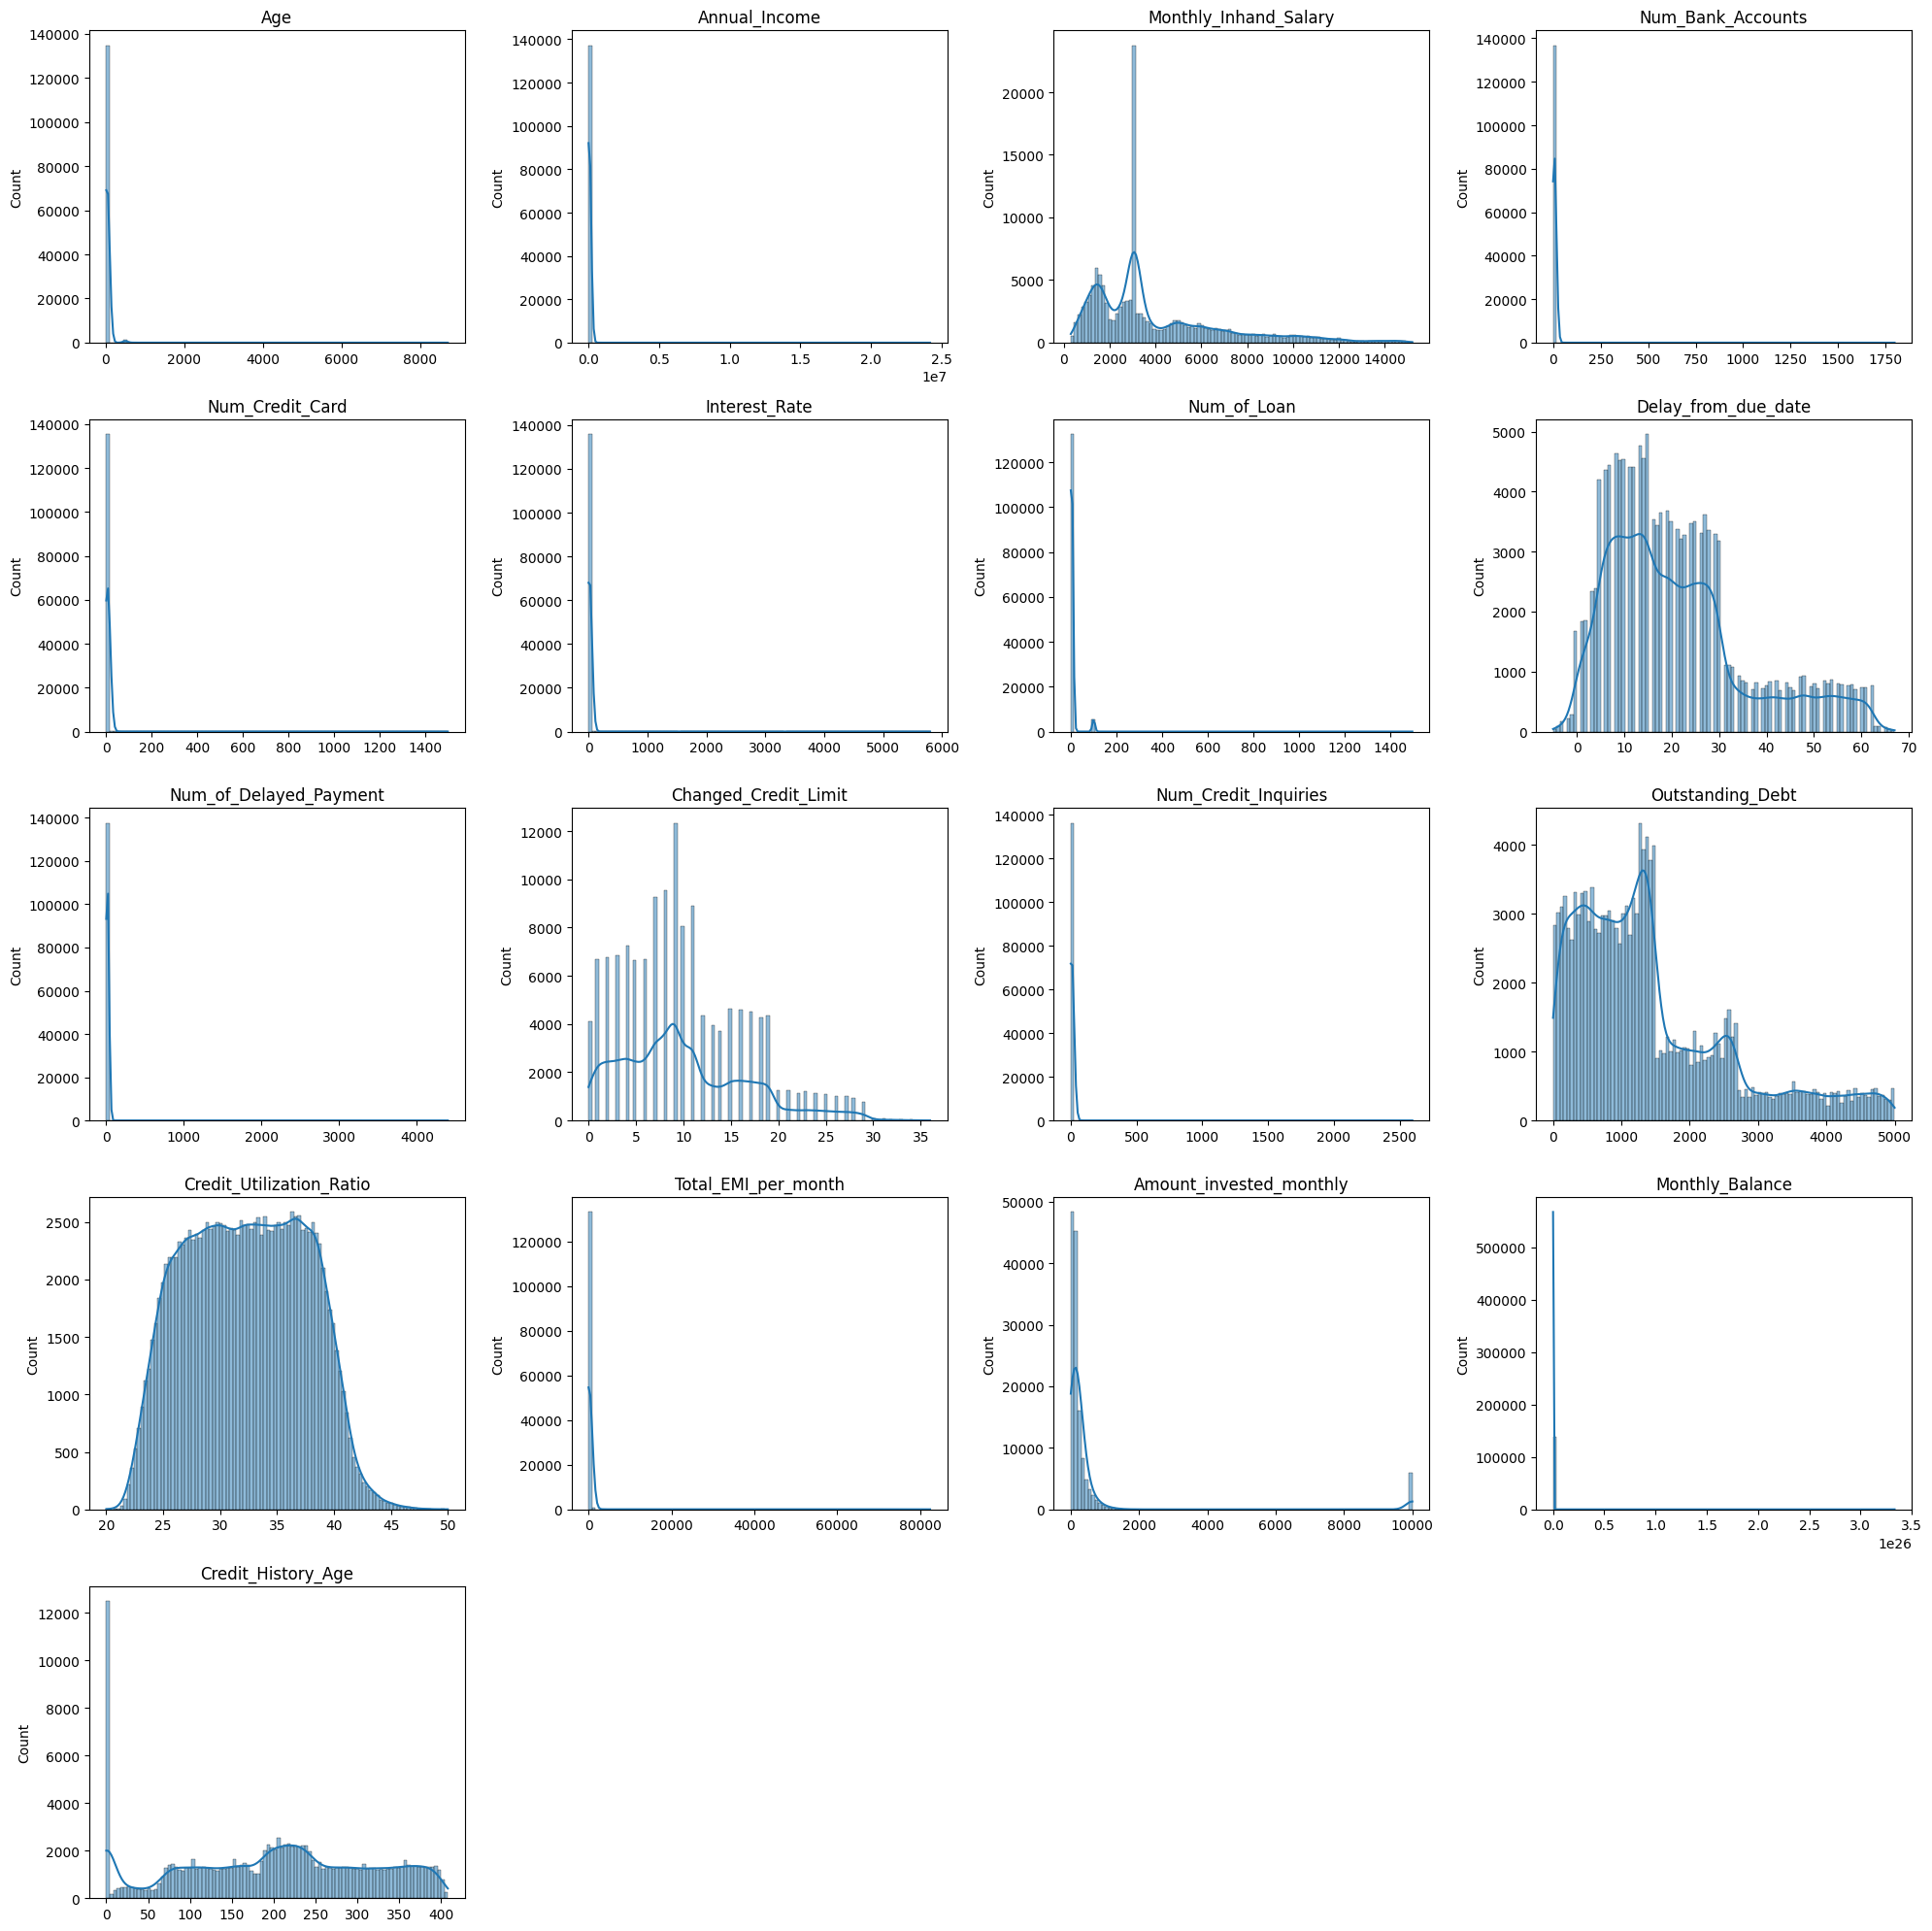

In [14]:
def plot_histograms(df, columns, rows=2, cols=3):

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten() 

    for i, col in enumerate(columns):
        if i < len(axes):  
            sns.histplot(df[col], kde=True, ax=axes[i], bins=100)
            axes[i].set_title(col)
            axes[i].set_xlabel('')  

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_histograms(df, num_cols, rows=5, cols=4)

In [15]:
df = df[df["Credit_History_Age"] != 0]

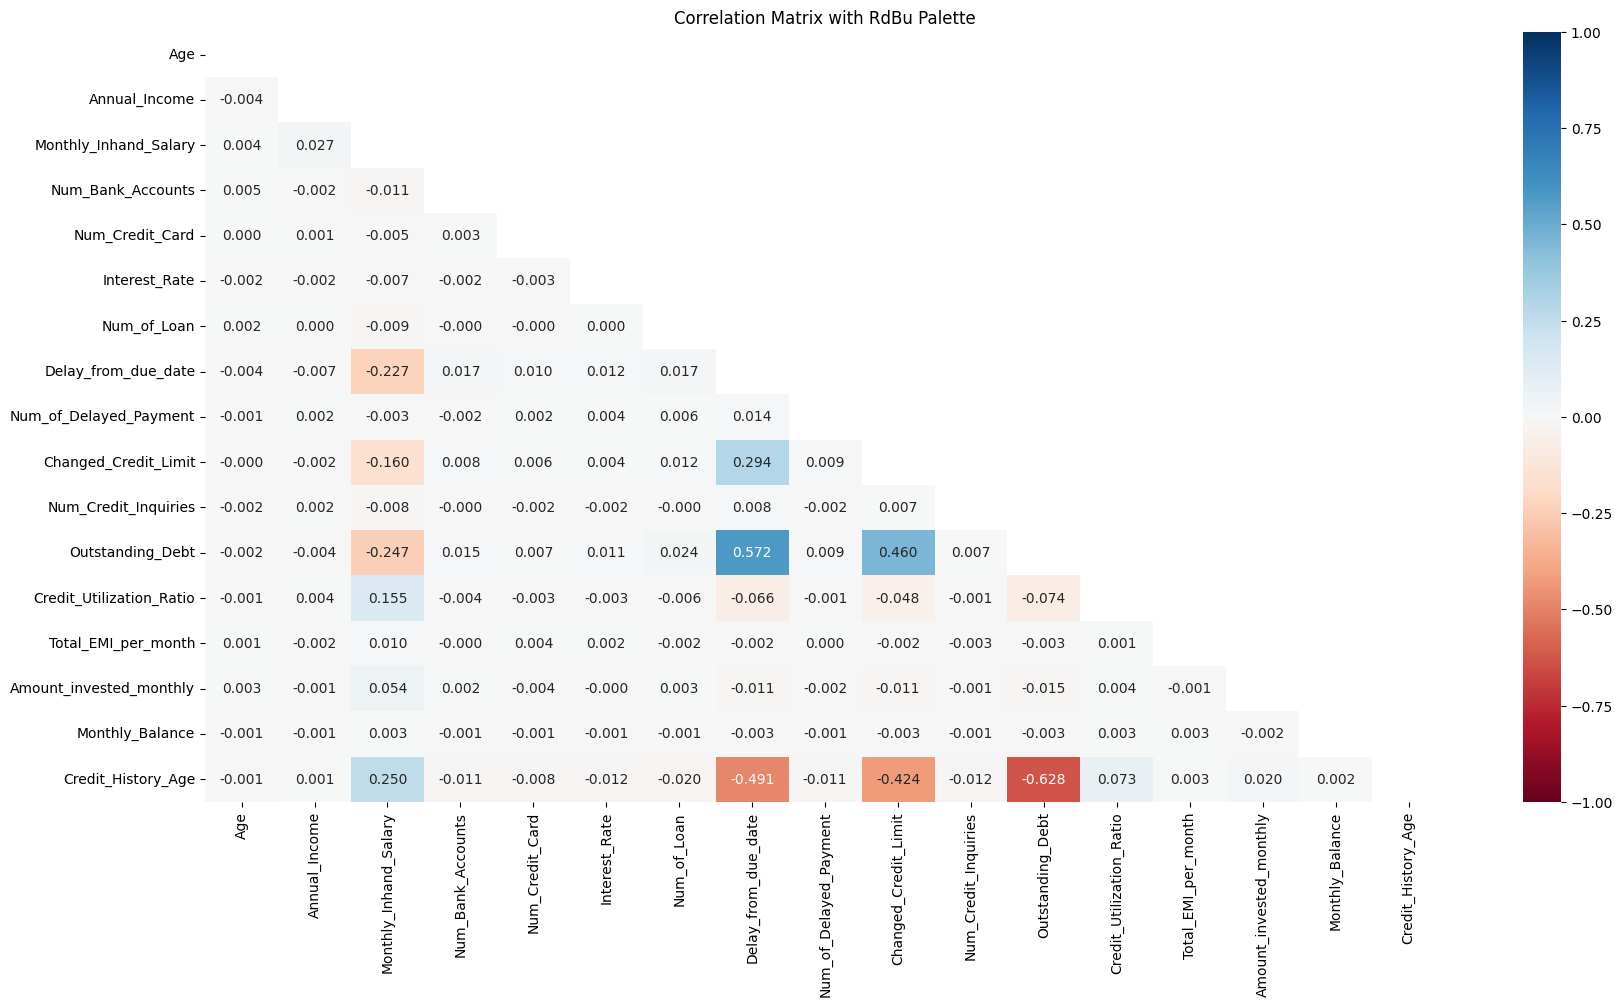

In [16]:
corr = df[num_cols].corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 10))
sns.heatmap(
    corr, 
    annot=True, 
    mask=mask, 
    fmt=".3f", 
    annot_kws={"fontsize": 10},
    cmap="RdBu",  
    vmin=-1,  
    vmax=1    
)
plt.title("Correlation Matrix with RdBu Palette")
plt.show()

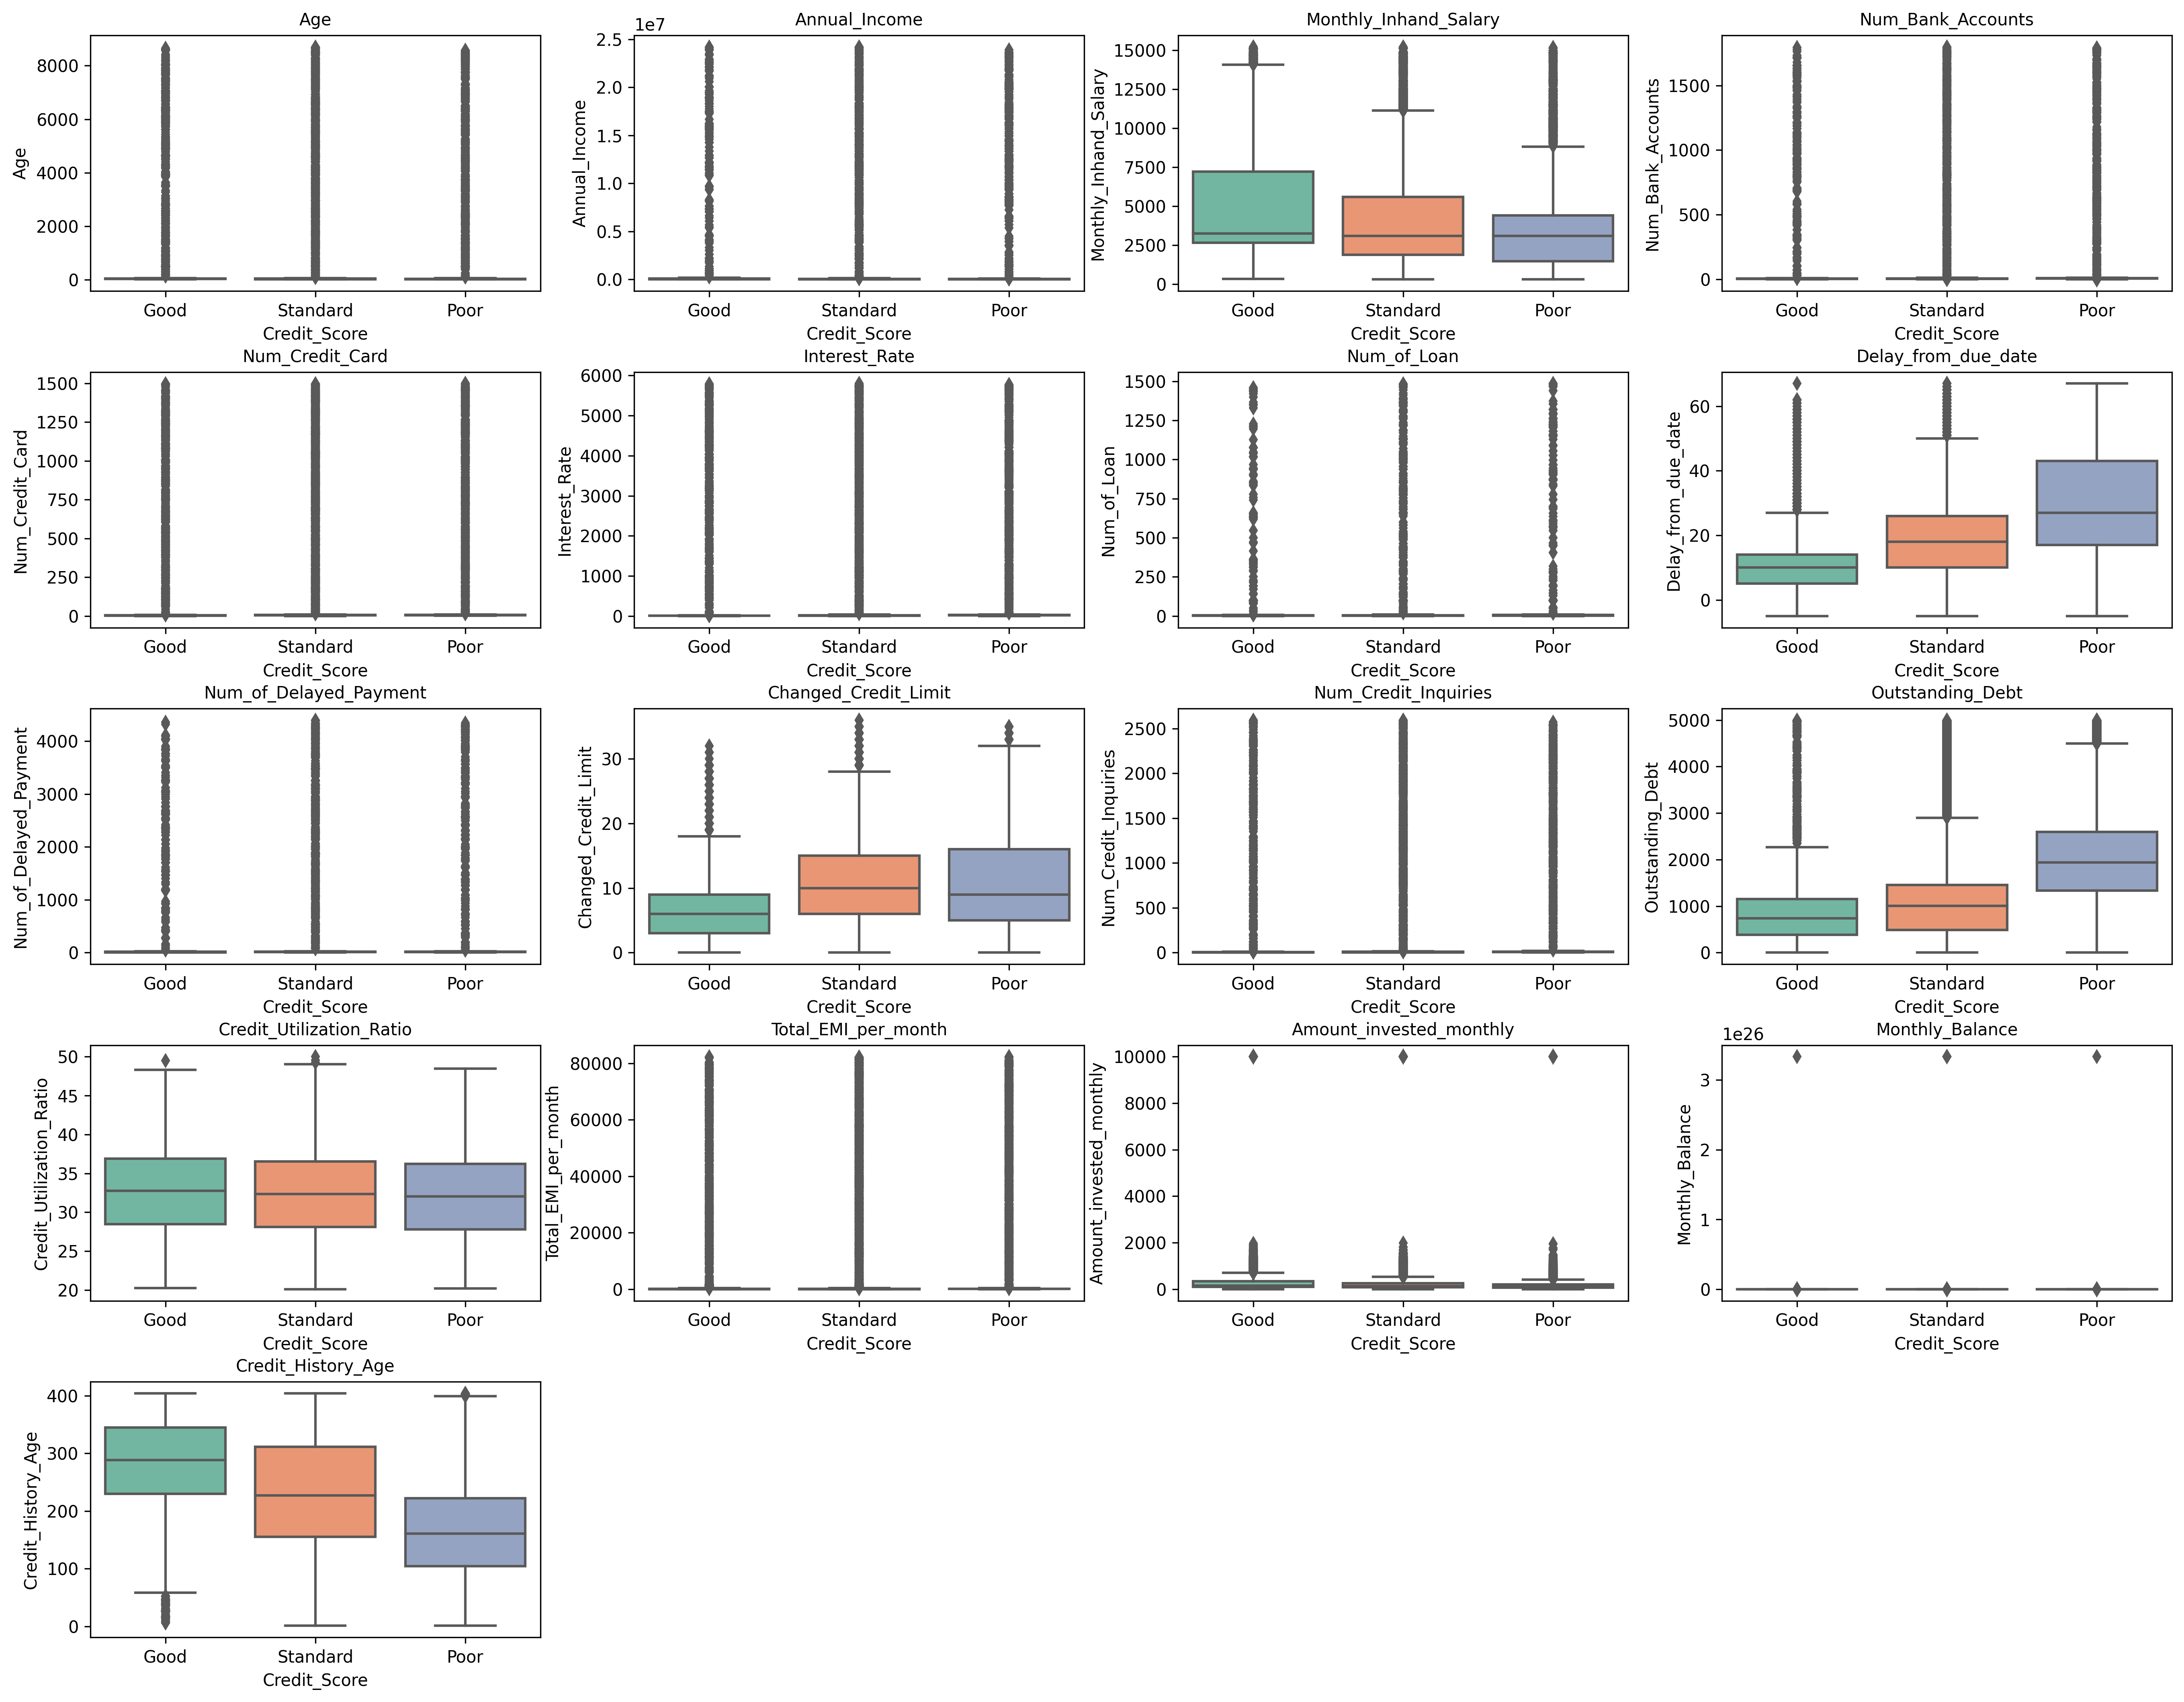

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def create_boxplots(dataframe, numeric_columns, target_column, figsize=(18, 14), dpi=300):

    df = dataframe.copy()
    df = df.reset_index(drop=True)
    
    n_cols = len(numeric_columns)
    n_rows = (n_cols + 3) // 4  # Calculate number of rows needed (4 plots per row)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    matplotlib.rc(("xtick", "ytick", "text"), c="k")
    matplotlib.rc("figure", dpi=80)
    
    for idx, column in enumerate(numeric_columns, 1):
        ax = fig.add_subplot(n_rows, 4, idx)
        
        sns.boxplot(
            data=df,
            x=target_column,
            y=column,
            ax=ax,
            width=0.8,
            palette="Set2"
        )
        
        ax.set_title(column, fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        
    plt.tight_layout(pad=0.3)
    plt.show()
create_boxplots(df, num_cols, 'Credit_Score')

# Categorical Columns Analysis & Cleaning

In [18]:
def analyze_categorical_columns(df, categorical_columns, plot=True):
    """
    Analyze categorical columns in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        categorical_columns (list): List of categorical column names.
        plot (bool, optional): Whether to display plots. Defaults to True.
    """

    for col in categorical_columns:
        print(f"\nAnalysis for column: {col}")
        print("##################################################")
        print(f"Unique values count: {df[col].nunique()}")
        print(f"Unique values: {df[col].unique()}")
        print(f"Value counts:\n{df[col].value_counts()}")

        if plot:
            plt.figure(figsize=(6, 3))
            # Using seaborn's countplot for better visualization
            ax = sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette="coolwarm")

            # Adding the count numbers on top of the bars
            for p in ax.patches:
                ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 5, p.get_y() + p.get_height() / 2),
                            ha='center', va='center')

            plt.title(f'{col} - Category Frequencies')
            plt.show()
        print("##################################################")

analyze_categorical_columns(df, cat_cols, False)


Analysis for column: Occupation
##################################################
Unique values count: 16
Unique values: ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']
Value counts:
Occupation
_______          8871
Lawyer           8273
Architect        8068
Mechanic         7984
Engineer         7977
Scientist        7944
Accountant       7933
Teacher          7907
Developer        7846
Entrepreneur     7843
Media_Manager    7796
Journalist       7687
Doctor           7650
Manager          7545
Musician         7462
Writer           7370
Name: count, dtype: int64
##################################################

Analysis for column: Credit_Mix
##################################################
Unique values count: 4
Unique values: ['_' 'Good' 'Standard' 'Bad']
Value counts:
Credit_Mix
Standard    46145
Good        30761
_           25261
Bad  

Occupation column removed 16667 rows.
Credit_Mix column removed 21943 rows.
Spending_Level column removed 0 rows.
Payment_Value column removed 0 rows.
Payment_of_Min_Amount column removed 0 rows.

Analysis for column: Occupation
##################################################
Unique values count: 14
Unique values: ['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician' 'Mechanic'
 'Writer' 'Architect']
Value counts:
Occupation
Lawyer          6626
Architect       6478
Accountant      6408
Mechanic        6391
Engineer        6376
Scientist       6346
Teacher         6274
Developer       6274
Entrepreneur    6245
Journalist      6184
Doctor          6113
Manager         5990
Musician        5969
Writer          5872
Name: count, dtype: int64


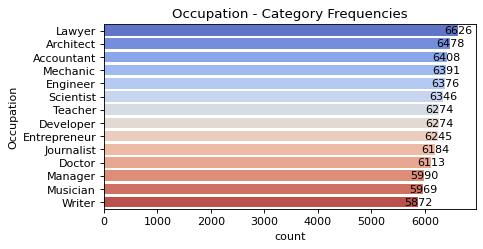

##################################################

Analysis for column: Credit_Mix
##################################################
Unique values count: 3
Unique values: ['Good' 'Standard' 'Bad']
Value counts:
Credit_Mix
Standard    39891
Good        26701
Bad         20954
Name: count, dtype: int64


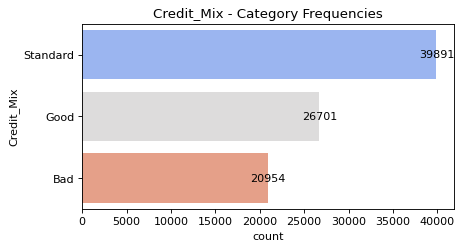

##################################################

Analysis for column: Spending_Level
##################################################
Unique values count: 2
Unique values: ['Low' 'High']
Value counts:
Spending_Level
Low     47047
High    40499
Name: count, dtype: int64


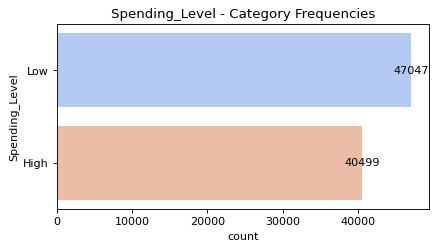

##################################################

Analysis for column: Payment_Value
##################################################
Unique values count: 3
Unique values: ['Medium' 'Small' 'Large']
Value counts:
Payment_Value
Small     34824
Medium    29819
Large     22903
Name: count, dtype: int64


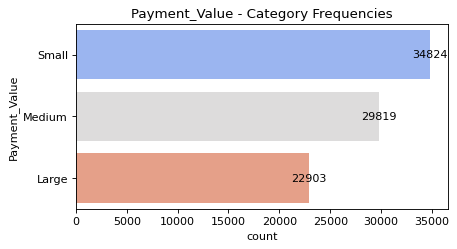

##################################################

Analysis for column: Payment_of_Min_Amount
##################################################
Unique values count: 3
Unique values: ['No' 'NM' 'Yes']
Value counts:
Payment_of_Min_Amount
Yes    45712
No     31310
NM     10524
Name: count, dtype: int64


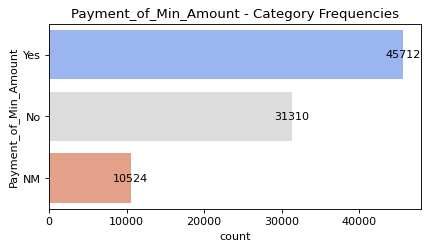

##################################################


In [19]:
def remove_underscore_rows(df, column_name):

    filtered_df = df[~df[column_name].str.contains('_', na=False)]
    
    removed_rows = len(df) - len(filtered_df)
    print(f"{column_name} column removed {removed_rows} rows.")
    
    return filtered_df

for col in cat_cols:
    df = remove_underscore_rows(df, col)  

analyze_categorical_columns(df, cat_cols, True)

In [20]:
replace = {"NM": "No"}  
df["Payment_of_Min_Amount"] = df["Payment_of_Min_Amount"].replace(replace)
df["Payment_of_Min_Amount"].value_counts()

Payment_of_Min_Amount
Yes    45712
No     41834
Name: count, dtype: int64

# Preprocess Data for Model

In [21]:
train_data = df[df['is_train'] == True].drop(columns=['is_train'])
test_data = df[df['is_train'] == False].drop(columns=['is_train'])

X = train_data.drop(columns=['Credit_Score'])
y = train_data['Credit_Score']
X_test = test_data.drop(columns=['Credit_Score'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [23]:
for index, class_name in enumerate(label_encoder.classes_):
    print(f"Class '{class_name}' is encoded as {index}")

Class 'Good' is encoded as 0
Class 'Poor' is encoded as 1
Class 'Standard' is encoded as 2


In [24]:
df["Credit_Score"].value_counts()

Credit_Score
Standard    30805
Poor        16943
Good        10377
Name: count, dtype: int64

In [25]:
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
one_hot_cols = ["Occupation", "Payment_of_Min_Amount"]
ordinal_cols = ["Credit_Mix", "Spending_Level", "Payment_Value"]

ordinal_categories = [
    ['Bad', 'Standard', 'Good'],  
    ['Low', 'High'],    
    ['Small', 'Medium', 'Large']
]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),  
        ('one_hot_enc', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),  
        ('ordinal_enc', OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols)
    ]
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# SMOTE model

In [26]:
from collections import Counter
print("Before:", Counter(y_train_encoded))
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("After:", Counter(y_train_resampled))

Before: Counter({2: 24644, 1: 13554, 0: 8302})
After: Counter({2: 24644, 1: 24644, 0: 24644})


ANN Model

In [27]:
from tensorflow.keras.layers import BatchNormalization

In [28]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)
    
    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [29]:
model = Sequential([
    Dense(512, activation='relu'),
    BatchNormalization(),


    Dense(512, activation='relu'),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),

    
    Dense(256, activation='relu'),
    BatchNormalization(),

    
    Dense(128, activation='relu'),
    BatchNormalization(),

    
    Dense(64, activation='relu'),
    BatchNormalization(),

    
    Dense(64, activation='relu'),
    BatchNormalization(),


    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(3, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=35,
                               restore_best_weights=True)


history = model.fit(x=X_train_resampled,
                    y=y_train_resampled,
                    validation_data=(X_val, y_val_encoded),
                    validation_split=0.2,
                    batch_size=512,
                    epochs=600,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6083 - loss: 0.8977 - val_accuracy: 0.3028 - val_loss: 9303785000140800.0000
Epoch 2/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6686 - loss: 0.7496 - val_accuracy: 0.3108 - val_loss: 3024579320610816.0000
Epoch 3/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6732 - loss: 0.7404 - val_accuracy: 0.3318 - val_loss: 9558900688814080.0000
Epoch 4/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6873 - loss: 0.7164 - val_accuracy: 0.2995 - val_loss: 10664763499479040.0000
Epoch 5/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6986 - loss: 0.6985 - val_accuracy: 0.5850 - val_loss: 0.8564
Epoch 6/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7117 - loss: 0.6779 - val_accuracy: 0.5406 - val_loss: 0.9100
Epoch 7/600
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7214 - loss: 0.6587 - val_accuracy: 0.4787 - val_loss: 112938647539417088.0000
Epoch 8/600

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,593,227 (6.08 MB)

 Trainable params: 529,859 (2.02 MB)

 Non-trainable params: 3,648 (14.25 KB)

 Optimizer params: 1,059,720 (4.04 MB)

In [31]:
eval_metric(model, X_train_resampled,y_train_resampled, X_val, y_val_encoded)

2311/2311 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Set:
[[ 789  181 1105]
 [  95 1967 1327]
 [ 431 1516 4214]]
              precision    recall  f1-score   support

           0       0.60      0.38      0.47      2075
           1       0.54      0.58      0.56      3389
           2       0.63      0.68      0.66      6161

    accuracy                           0.60     11625
   macro avg       0.59      0.55      0.56     11625
weighted avg       0.60      0.60      0.59     11625


Train Set:
[[ 9815  2198 12631]
 [  602 14569  9473]
 [ 1789  6110 16745]]
              precision    recall  f1-score   support

           0       0.80      0.40      0.53     24644
           1       0.64      0.59      0.61     24644
           2       0.43      0.68      0.53     24644

    accuracy                           0.56     73932
   macro avg       0.62      0.56      0.56     73932
weighted avg       0.62      0.56      0.56     73932



# Taking out outliers

In [32]:
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
num_cols.remove("is_train")

def outlier_ratio(dataframe, column):
    lower_bound, upper_bound = outlier_bounds(dataframe, column)
    train_mask = dataframe["is_train"] == True  # Sadece train verisini seç
    total_count = dataframe[train_mask].shape[0]
    outlier_count = dataframe[(train_mask) & 
                              ((dataframe[column] < lower_bound) | (dataframe[column] > upper_bound))].shape[0]
    
    return (outlier_count / total_count) * 100 if total_count > 0 else 0

def outlier_bounds(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


def remove_outliers(dataframe, column):
    lower_bound, upper_bound = outlier_bounds(dataframe, column)
    train_mask = dataframe["is_train"] == True  # Sadece train verisini seç
    outlier_indices = dataframe[(train_mask) & 
                                ((dataframe[column] < lower_bound) | (dataframe[column] > upper_bound))].index
    dataframe.drop(outlier_indices, inplace=True)


for col in num_cols:
    remove_outliers(df, col)
    ratio = outlier_ratio(df[df["is_train"] == True], col)  
    print(f"{col} : %{ratio}")

Age : %0.0
Annual_Income : %0.5969171413492511
Monthly_Inhand_Salary : %2.2141820717206553
Num_Bank_Accounts : %0.02672571777642028
Num_Credit_Card : %0.0
Interest_Rate : %0.0
Num_of_Loan : %0.0
Delay_from_due_date : %1.9319567868966718
Num_of_Delayed_Payment : %0.0
Changed_Credit_Limit : %0.0
Num_Credit_Inquiries : %0.6317076484173346
Outstanding_Debt : %3.559746926107198
Credit_Utilization_Ratio : %0.0
Credit_History_Age : %0.0
Total_EMI_per_month : %3.8737336361548476
Amount_invested_monthly : %5.021086298151765
Monthly_Balance : %4.203231858621316


In [33]:
df.to_csv("without_outliers.csv", index=False)   
df = pd.read_csv("without_outliers.csv")
df[df['is_train'] == True]['Credit_Score'].value_counts()

Credit_Score
Standard    17929
Poor         9621
Good         5496
Name: count, dtype: int64

In [34]:
train_data = df[df['is_train'] == True].drop(columns=['is_train'])
test_data = df[df['is_train'] == False].drop(columns=['is_train'])

X = train_data.drop(columns=['Credit_Score'])
y = train_data['Credit_Score']
X_test = test_data.drop(columns=['Credit_Score'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val) 

num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
one_hot_cols = ["Occupation", "Payment_of_Min_Amount"]
ordinal_cols = ["Credit_Mix", "Spending_Level", "Payment_Value"]

ordinal_categories = [
    ['Bad', 'Standard', 'Good'],  
    ['Low', 'High'],    
    ['Small', 'Medium', 'Large']
] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),  
        ('one_hot_enc', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),  
        ('ordinal_enc', OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols)
    ]
) 

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [35]:
unique_classes = np.unique(y_train)
class_weight_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)
class_weight_dict = {int(i): float(w) for i, w in zip(unique_classes, class_weight_array)}
print("Class weights:", class_weight_dict)


model = Sequential([
    Input(shape=(X_train.shape[1],)),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(3, activation='softmax')
]) 


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping], 
    class_weight=class_weight_dict
)

Class weights: {0: 2.0040937002501704, 1: 1.145010395010395, 2: 0.614376350833159}
Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5761 - loss: 1.0283 - val_accuracy: 0.6191 - val_loss: 0.8880
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6739 - loss: 0.7530 - val_accuracy: 0.6766 - val_loss: 0.8270
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6886 - loss: 0.7186 - val_accuracy: 0.7047 - val_loss: 0.7617
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6870 - loss: 0.7021 - val_accuracy: 0.7045 - val_loss: 0.7303
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6989 - loss: 0.6842 - val_accuracy: 0.6970 - val_loss: 0.7265
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7016 - loss: 0.6701 - val_accuracy: 0.6988 - val_loss: 0.7100
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7056 - loss: 0.6687 - val_accuracy: 0.7044 - val_loss: 0.7187
Epoch 8

In [36]:
eval_metric(model, X_train,y_train, X_val,  y_val)

827/827 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Set:
[[ 901   40  158]
 [ 106 1516  303]
 [ 493  615 2478]]
              precision    recall  f1-score   support

           0       0.60      0.82      0.69      1099
           1       0.70      0.79      0.74      1925
           2       0.84      0.69      0.76      3586

    accuracy                           0.74      6610
   macro avg       0.71      0.77      0.73      6610
weighted avg       0.76      0.74      0.74      6610


Train Set:
[[ 4387     4     6]
 [   25  7516   155]
 [ 1226  1559 11558]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4397
           1       0.83      0.98      0.90      7696
           2       0.99      0.81      0.89     14343

    accuracy                           0.89     26436
   macro avg       0.86      0.93      0.89     26436
weighted avg       0.91      0.89      0.89     26436



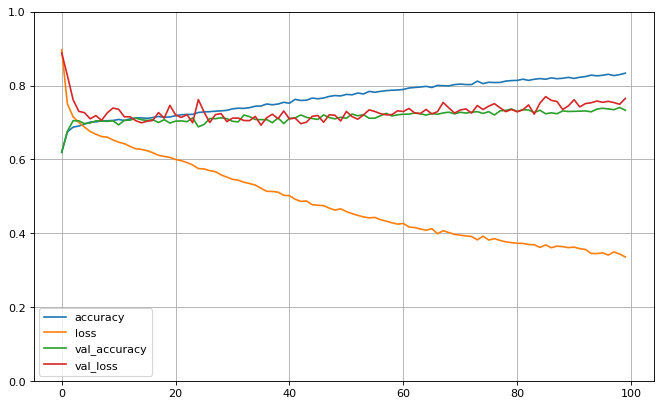

In [37]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()